### RWSE-Checker: true-positives statistics from filtered corpus

In [1]:
from rwse import RWSE_Checker
import os
import pickle
import spacy

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rwse = RWSE_Checker()
rwse.set_confusion_sets('input/confusion_sets_modified.csv')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` 

#### Read from corpus and collect sentences by confusion sets

In [3]:
from util.helper import collect_sentences_by_confusion_sets

with open('input/eng_news_2023_10K-sentences.txt', 'r') as f:
    sentences = f.readlines()

sentences_cleaned = [sentence.split('\t')[1].strip() for sentence in sentences]

sentences_by_confusion_sets = collect_sentences_by_confusion_sets(rwse.confusion_sets.values(), sentences_cleaned)

total = 0
for key, value in sentences_by_confusion_sets.items():
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

Except,accept,except = 21
advice,advise = 21
Effect,affect,effect = 31
Being,begin,being = 214
bitch,pitch = 7
brakes,breaks = 7
Capital,Capitol,capital = 50
Site,sight,site = 30
Country,County,country,county = 135
crab,crap = 2
Desert,desert,dessert = 7
Easy,ease,easy = 32
Effects,affects,effects = 23
extend,extent = 16
feat,feet = 21
Few,View,few,view = 108
Form,From,form,from = 861
Fourth,forth,fourth = 36
forms,forums = 3
Found,Fund,found,fund = 126
Lead,Led,lead,led = 95
Life,Live,life,live = 162
loose,lose = 20
Mad,Made,mad,made = 155
Or,or,ore = 423
Past,passed,past = 81
Peace,Piece,peace,piece = 31
Plain,plain,plane = 12
Principal,principal,principle = 13
Provence,Province,province = 10
Quiet,Quite,quiet,quite = 37
Rise,raise,rise = 36
Safe,Save,safe,save = 50
Split,spit,split = 9
Than,Then,than,then = 433
Their,There,They,their,there,they = 1530
Them,Theme,them,theme = 248
Things,things,thinks = 70
Trail,Trial,trail,trial = 33
Three,Tree,three,tree = 181
To,Too,Two,to,too,two 

#### Switch confusion words in sentences

In [4]:
from util.helper import replace_confusion_set_words_in_sentences

file_name = 'output/falsified_eng_new_2023_10K-sentences.pkl'

if not os.path.exists(file_name):
    nlp = spacy.load("en_core_web_sm")
    modified_sentences_by_confusion_sets = replace_confusion_set_words_in_sentences(sentences_by_confusion_sets, nlp)
    with open(file_name, 'wb') as f:
        pickle.dump(modified_sentences_by_confusion_sets, f)
else:
    modified_sentences_by_confusion_sets = pickle.load(open(file_name, 'rb'))


total = 0
for key, value in modified_sentences_by_confusion_sets.items():
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

Except,accept,except = 30
advice,advise = 21
Effect,affect,effect = 41
Being,begin,being = 250
bitch,pitch = 7
brakes,breaks = 7
Capital,Capitol,capital = 54
Site,sight,site = 32
Country,County,country,county = 290
crab,crap = 2
Desert,desert,dessert = 11
Easy,ease,easy = 37
Effects,affects,effects = 27
extend,extent = 16
feat,feet = 22
Few,View,few,view = 218
Form,From,form,from = 1838
Fourth,forth,fourth = 44
forms,forums = 3
Found,Fund,found,fund = 258
Lead,Led,lead,led = 194
Life,Live,life,live = 332
loose,lose = 20
Mad,Made,mad,made = 314
Or,or,ore = 454
Past,passed,past = 105
Peace,Piece,peace,piece = 64
Plain,plain,plane = 24
Principal,principal,principle = 16
Provence,Province,province = 10
Quiet,Quite,quiet,quite = 78
Rise,raise,rise = 47
Safe,Save,safe,save = 106
Split,spit,split = 9
Than,Then,than,then = 892
Their,There,They,their,there,they = 7440
Them,Theme,them,theme = 522
Things,things,thinks = 79
Trail,Trial,trail,trial = 68
Three,Tree,three,tree = 368
To,Too,Two,to,too

#### Determine RWSEs

In [5]:
from cassis import Cas, load_typesystem
import spacy

T_SENTENCE = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence'
T_RWSE = 'de.tudarmstadt.ukp.dkpro.core.api.anomaly.type.RWSE'
T_TOKEN = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token'

nlp = spacy.load('en_core_web_sm')

path = 'input/TypeSystem.xml'

with open(path, 'rb') as f:
    ts = load_typesystem(f)

S = ts.get_type(T_SENTENCE)
T = ts.get_type(T_TOKEN)

In [6]:
file_name = 'output/false_negatives.csv'

with open('output/false_negatives.csv', 'w') as f:

    result = dict()

    for confusion_set, box in modified_sentences_by_confusion_sets.items():
        rwse.set_confusion_sets([set(confusion_set.split(','))])
        matches = 0
        for item in box:
            cas = Cas(ts)
            sentence = item['sentence']
            # TODO clean sentence?
            cas.sofa_string = sentence
            doc = nlp(cas.sofa_string)
            cas_sentence = S(begin=0, end=len(sentence))
            cas.add(cas_sentence)
            for token in doc:
                cas_token = T(begin=token.idx, end=token.idx+len(token.text), id=token.i)
                cas.add(cas_token)
            rwse.check_cas(cas, ts)
            true_positives = cas.select(T_RWSE)
            if len(true_positives) == 0:
                before = sentence[item['new_token']['begin']:item['new_token']['end']]
                modified_string = sentence[:item['new_token']['begin']] + ' [[' + item['new_token']['word'] + ']] ' + sentence[item['new_token']['end']:]
                print(f"expected suggestion: {item['org_word']}", f"for token: {item['new_token']['word']}" , modified_string, sep='\t', file=f)
            else:
                matches += 1
        result[confusion_set] = {
            'num_sentences':len(box),
            'num_matches':matches,
        }

#### Determine Sensitivity (True-Positive-Rate)

In [7]:
total = sum(item['num_sentences'] for item in result.values())
total_matches = sum(item['num_matches'] for item in result.values())
print(f'true positive rate: {total_matches/total:.2f}')
print(f'correctly identified {total_matches} out of {total}')

true positive rate: 0.99
correctly identified 44256 out of 44893


In [8]:
with open('output/report_true_positives.csv', 'w') as f:
    print('confusion_set', 'num_matches', 'num_sentences', sep=';', file=f)
    for key, value in result.items():
        print(key, value['num_matches'], value['num_sentences'], sep=';', file=f)
        print(key, value['num_matches'], value['num_sentences'], sep='\t')

Except,accept,except	29	30
advice,advise	21	21
Effect,affect,effect	39	41
Being,begin,being	250	250
bitch,pitch	7	7
brakes,breaks	7	7
Capital,Capitol,capital	49	54
Site,sight,site	31	32
Country,County,country,county	266	290
crab,crap	1	2
Desert,desert,dessert	11	11
Easy,ease,easy	36	37
Effects,affects,effects	27	27
extend,extent	16	16
feat,feet	21	22
Few,View,few,view	218	218
Form,From,form,from	1828	1838
Fourth,forth,fourth	44	44
forms,forums	3	3
Found,Fund,found,fund	256	258
Lead,Led,lead,led	188	194
Life,Live,life,live	318	332
loose,lose	19	20
Mad,Made,mad,made	314	314
Or,or,ore	454	454
Past,passed,past	103	105
Peace,Piece,peace,piece	63	64
Plain,plain,plane	23	24
Principal,principal,principle	15	16
Provence,Province,province	10	10
Quiet,Quite,quiet,quite	78	78
Rise,raise,rise	40	47
Safe,Save,safe,save	102	106
Split,spit,split	9	9
Than,Then,than,then	882	892
Their,There,They,their,there,they	7201	7440
Them,Theme,them,theme	519	522
Things,things,thinks	78	79
Trail,Trial,trail,trial	6

<Axes: xlabel='confusion_set'>

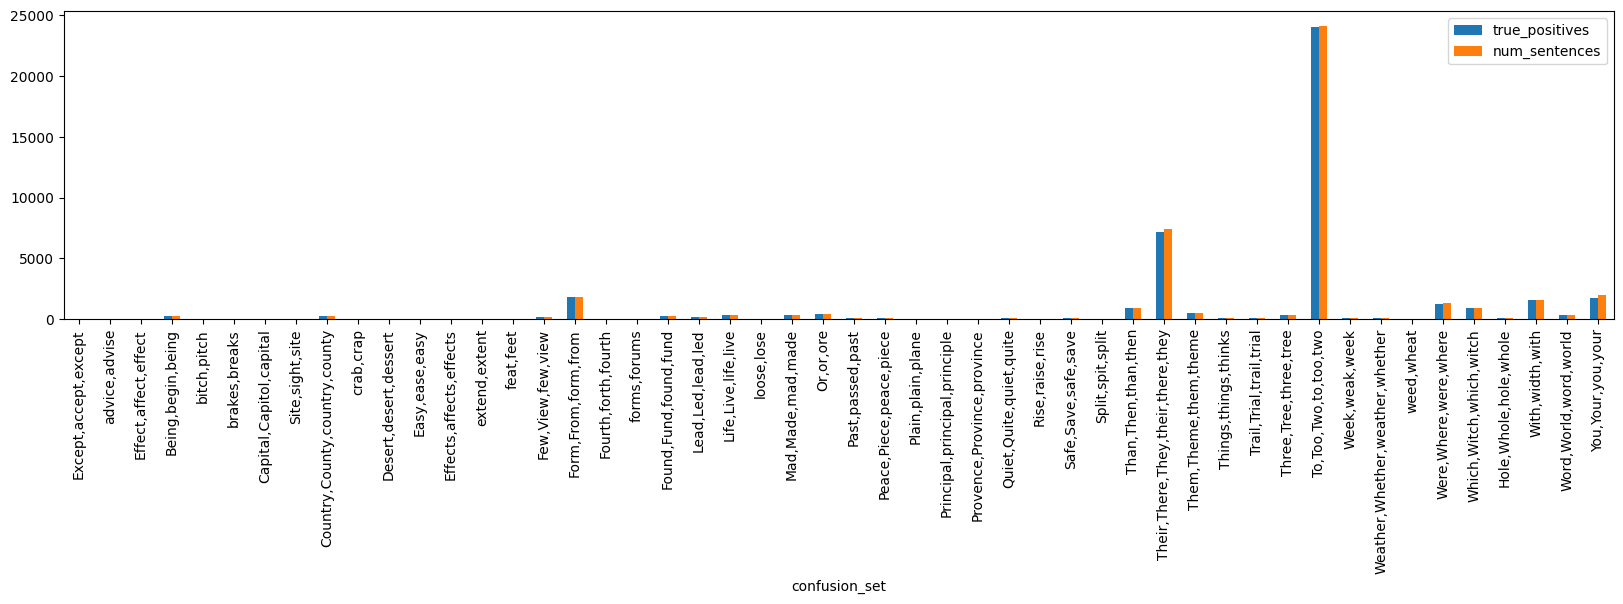

In [9]:
import pandas as pd

tp_df = pd.read_csv('output/report_true_positives.csv', sep=';')#[['confusion_set', 'num_sentences']]
tp_df.columns = ['confusion_set', 'true_positives', 'num_sentences']
tp_df.index = tp_df['confusion_set']
tp_df.plot(kind="bar", figsize=(20,4))

#### Determine Mean Sensitivity

In [10]:
data_true_positives = dict()
with open('output/report_true_positives.csv', 'r') as f:
    lines = f.readlines()
    for line in lines[1:]:
        confusion_set, num_matches, num_sequences = line.strip().split(';')
        data_true_positives[confusion_set] = (int(num_matches), int(num_sequences))

mean_sensitivity = 0
data_mean_sensitivity = dict()
for key, item in data_true_positives.items():
    if item[1] > 0:
        value = item[0]/item[1]
        print(f'{key}: {value:.10f}')
        mean_sensitivity += value
        data_mean_sensitivity[key] = value
    else:
        print(f'No data for {key}.')

mean_sensitivity /= len(data_true_positives)

print(f'Mean Sensitivity = {mean_sensitivity:.10f}')

Except,accept,except: 0.9666666667
advice,advise: 1.0000000000
Effect,affect,effect: 0.9512195122
Being,begin,being: 1.0000000000
bitch,pitch: 1.0000000000
brakes,breaks: 1.0000000000
Capital,Capitol,capital: 0.9074074074
Site,sight,site: 0.9687500000
Country,County,country,county: 0.9172413793
crab,crap: 0.5000000000
Desert,desert,dessert: 1.0000000000
Easy,ease,easy: 0.9729729730
Effects,affects,effects: 1.0000000000
extend,extent: 1.0000000000
feat,feet: 0.9545454545
Few,View,few,view: 1.0000000000
Form,From,form,from: 0.9945593036
Fourth,forth,fourth: 1.0000000000
forms,forums: 1.0000000000
Found,Fund,found,fund: 0.9922480620
Lead,Led,lead,led: 0.9690721649
Life,Live,life,live: 0.9578313253
loose,lose: 0.9500000000
Mad,Made,mad,made: 1.0000000000
Or,or,ore: 1.0000000000
Past,passed,past: 0.9809523810
Peace,Piece,peace,piece: 0.9843750000
Plain,plain,plane: 0.9583333333
Principal,principal,principle: 0.9375000000
Provence,Province,province: 1.0000000000
Quiet,Quite,quiet,quite: 1.00

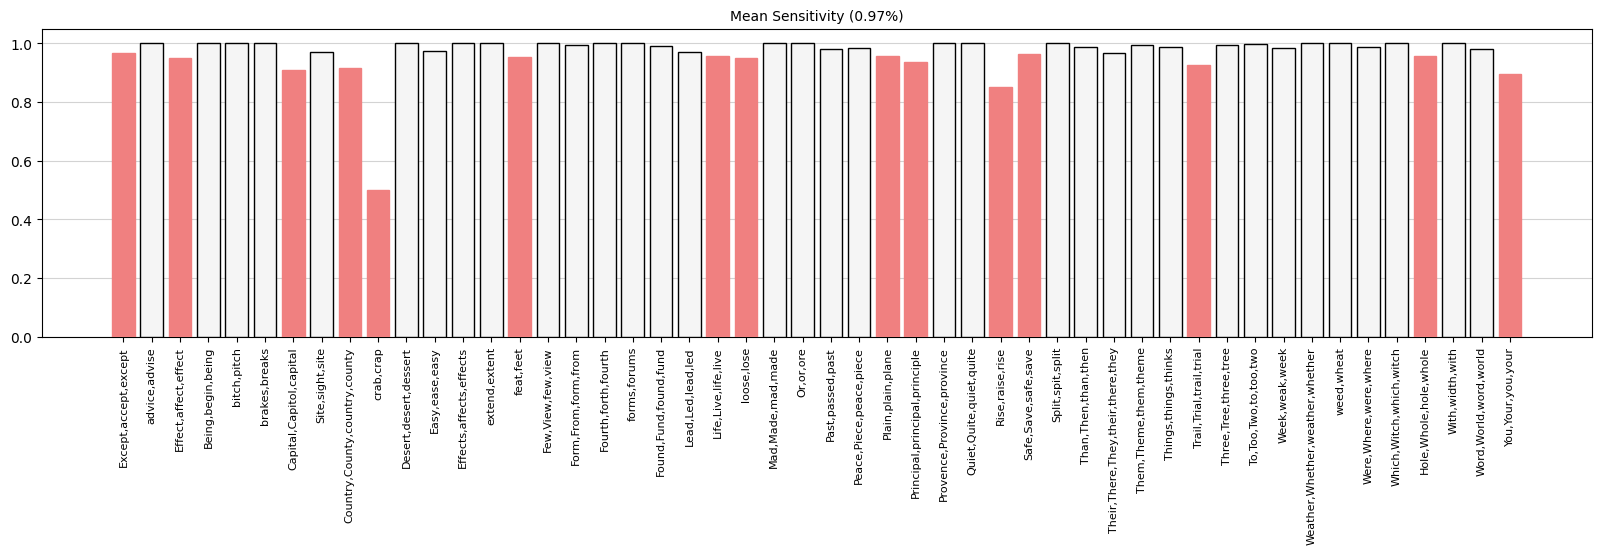

In [11]:
import matplotlib.pyplot as plt

xticks = list(range(len(data_mean_sensitivity)))
values = list(data_mean_sensitivity.values())
labels = list(data_mean_sensitivity.keys())

fig, ax = plt.subplots(figsize=(20,4))
ax.set_title(f"Mean Sensitivity ({mean_sensitivity:.2f}%)", fontsize=10)
#ax.plot(xticks, values, color="darkgrey")
bars = ax.bar(xticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value < mean_sensitivity:
        bars[idx].set_color('lightcoral')
#ax.plot(xticks,[b_tpr]*len(xticks), zorder=3, color="red", linewidth=1)
ax.set_xticks(xticks, labels, rotation='vertical')
ax.xaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)